# Behavorial-Cloning Project
## - Brian Erickson
This is my implementation of the Udacity Self Driving Car class project "Behavioral Cloning".

The goal is to record driving input and images using a driving simulator, use the recorded input and images to train a neural network that will predict steering angles and then use the predicted steering angles to drive the same car in the same simulator.

Installation: This is a linux based implementation.  The linux simulator should be installed in ../simulator

### Imports and Helper Functions

The helper functions below will be used throughout the notebook.

In [1]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
#import tensorflow as tf
import math
import time
import skimage.transform
import random
import os
from ipywidgets import widgets
from IPython.display import display
import keras
%matplotlib inline

Using TensorFlow backend.


In [2]:
# to make "random" calls predictable, use a fixed seed
# since I'm using random from  numpy, tensorflow and from the 
# standard python random, I have a single seed helper
# that will take care of all
def seed(n=32568):
    """
    Seeds the random number generators
    """
    np.random.seed(n)
    random.seed(n)
    tf.set_random_seed(n)

In [3]:
def plot_image(img,title=None):
    cmap = 'gray' if np.ndim(img) == 2 else None
    plt.axis('off')
    plt.imshow(img, cmap=cmap, interpolation='none')
    if title is not None:
        plt.title(title)

In [4]:
def random_sample(*lists, n=None):
    """
    Returns parallel lists with n random samples from lists without replacement
    """
    list_count = len(lists)
    list_length = len(lists[0])
    #print(list_count,list_length)
    if n is None:
        n = list_length
    if n > list_length:
        n = list_length
    indexes = list(range(list_length))
    np.random.shuffle(indexes)
    rv = [ [l[i] for i in indexes[:n]] for l in lists]
    if list_count==1:
        rv = rv[0]
    return rv
        

In [5]:
def split(*lists,n=None,ratio=None):
    if ratio is not None:
        n=int(len(lists[0])*ratio)
    rv = []
    for l in lists:
        rv.append(l[:n])
        rv.append(l[n:])
    return rv

In [6]:
a=[1,2,3,4,5,6]
b=[6,5,4,3,2,1]
c = random_sample(a,b)
split(*c,n=2)
print(random_sample(a))
print(random_sample(a,b))

[4, 5, 1, 3, 6, 2]
[[6, 2, 3, 5, 4, 1], [1, 5, 4, 2, 3, 6]]


### Simulator Execution
I enable manual simulator execution by adding a button to this notebook.  If everything is installed correctly, clicking the button will launch the simulator to allow you to manually collect training data.  After this is done once, you can use the training data throughout this notebook.

In [7]:
def run_simulator(b):
    !"../simulator/Default Linux desktop Universal.x86_64">/dev/null

def show_run_simulator_button():
    simulator_button = widgets.Button(description= "Run Simulator")
    simulator_button.on_click(run_simulator)
    display(simulator_button)

show_run_simulator_button()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [8]:
def read_driving_log():
    csv_path = 'recordings/driving_log.csv'
    csv_column_names = [
        'center_image_path',
        'left_image_path',
        'right_image_path',
        'steering_angle',
        'throttle',
        'brake',
        'speed']
    
    return pd.read_csv(csv_path, names=csv_column_names)

driving_log = read_driving_log()
                    


Here I show the first few rows of the log, we see that for each entry, there is a left, right, and center image as well as the conrol inputs and speed.  We will mainly be concentrating on the steering angle and center_image_path as these are designed to be the inputs and outputs of the system.

In [9]:
driving_log.describe()

,steering_angle,throttle,brake,speed
count,619.000000,619.000000,619.0,619.000000
mean,-0.060374,0.622154,0.0,23.389805
std,0.176892,0.458614,0.0,10.131922
min,-1.000000,0.000000,0.0,0.000007
25%,-0.022473,0.000000,0.0,21.481895
50%,0.000000,1.000000,0.0,29.175180
75%,0.000000,1.000000,0.0,30.190275
max,0.957430,1.000000,0.0,30.191310


In [10]:
center_images = [plt.imread(path) for path in driving_log.center_image_path]
steering_angles = driving_log.steering_angle.values



In [11]:
steering_angles

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.2403932 , -0.3184054 , -0.1076252 ,
       -0.4171286 , -0.1691666 ,  0.        , -0.1709461 , -0.3933628 ,
       -0.07422566, -0.06212425, -0.04684567,  0.        , -0.2041197 ,
       -0.4229965 , -0.308424  , -0.5422826 , -0.2626762 ,  0.        ,
        0.        ,  0.        , -0.08704805, -0.4011326 , -0.102602  ,
       -0.3832219 , -0.2000241 ,  0.        , -0.2631419 , -0.2403052 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.04837775, -0.3474691 , -0.07678771,  0.        ,  0.        ,
        0.        ,  0.        , -0.1269028 , -0.3096628 , -0.02123094,
        0.        ,  0.        ,  0.        ,  0.        , -0.1769493 ,
       -0.342315  , -0.06063294, -0.1219468 , -0.428313  , -0.13

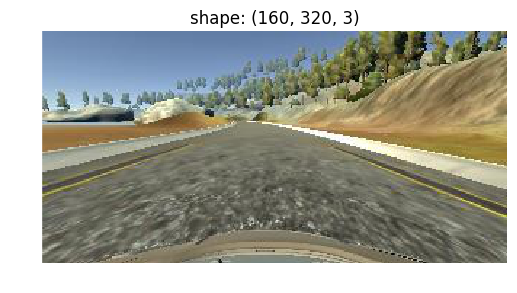

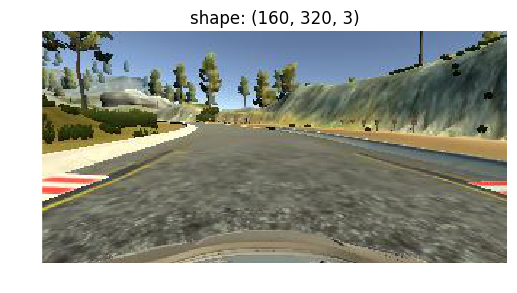

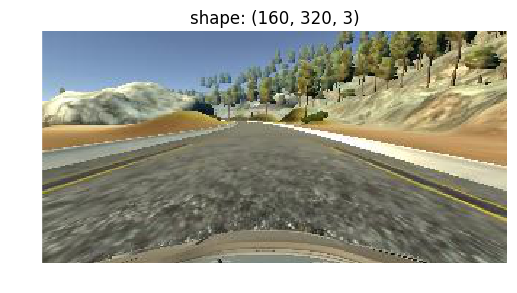

In [12]:
for im in random_sample(center_images,n=3):
    plt.figure()
    plot_image(im,title='shape: {}'.format(np.shape(im)))

In [13]:
model = keras.models.Sequential()


In [14]:
def show_run_simulator_button():
    simulator_button = widgets.Button(description= "Run Simulator")
    simulator_button.on_click(run_simulator)
    display(simulator_button)

show_run_simulator_button()

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


used this as a starter: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [15]:
X=np.array(center_images)
X = np.moveaxis(X,(0,1,2,3),(0,2,3,1))
y=np.array(steering_angles)
X_train,X_val=split(X,ratio=0.8)
y_train,y_val=split(y,ratio=0.8)
X_train=np.array(X_train)
X_val=np.array(X_val)
y_train=np.array(y_train)
y_val=np.array(y_val)


In [16]:
print(np.shape(X_train), np.shape(y_train), np.shape(X_val), np.shape(y_val))

print(np.shape(X_train), np.shape(y_train), np.shape(X_val), np.shape(y_val))

(495, 3, 160, 320) (495,) (124, 3, 160, 320) (124,)
(495, 3, 160, 320) (495,) (124, 3, 160, 320) (124,)


In [17]:
im_shape = X_train[0].shape
print(im_shape)

(3, 160, 320)


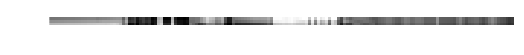

In [18]:
plot_image(X_train[0,:,:,2])

http://stackoverflow.com/questions/37088571/keras-loading-color-images

In [19]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(keras.layers.InputLayer(input_shape=im_shape))
model.add(Convolution2D(64, 3, 3,  border_mode='valid', activation='relu',name='conv1'))
print('conv1 output',model.output_shape)
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu',name='conv2'))
print('conv2 output', model.output_shape)
model.add(Flatten())
model.add(Dense(1))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])


model.fit(X_train, y_train,
          nb_epoch=50, batch_size=32,
          validation_data=(X_val, y_val))
#model.save_weights('model.h5')


conv1 output (None, 1, 158, 64)
conv2 output (None, 1, 158, 32)
Train on 495 samples, validate on 124 samples
Epoch 1/50
495/495 [==============================] - 2s - loss: 11726.0663 - acc: 0.0263 - val_loss: 0.6989 - val_acc: 0.2903
Epoch 2/50
495/495 [==============================] - 1s - loss: 0.2980 - acc: 0.4505 - val_loss: 0.5695 - val_acc: 0.3387
Epoch 3/50
495/495 [==============================] - 1s - loss: 0.2069 - acc: 0.5677 - val_loss: 0.4482 - val_acc: 0.4677
Epoch 4/50
495/495 [==============================] - 1s - loss: 0.1343 - acc: 0.6788 - val_loss: 0.3333 - val_acc: 0.5645
Epoch 5/50
495/495 [==============================] - 1s - loss: 0.0761 - acc: 0.7232 - val_loss: 0.1913 - val_acc: 0.6371
Epoch 6/50
495/495 [==============================] - 1s - loss: 0.0498 - acc: 0.7293 - val_loss: 0.1845 - val_acc: 0.6210
Epoch 7/50
495/495 [==============================] - 1s - loss: 0.0363 - acc: 0.7394 - val_loss: 0.1079 - val_acc: 0.6371
Epoch 8/50
495/495 [=====